[INFO] Using run directory: logs/pendulum_task2/PPO_1


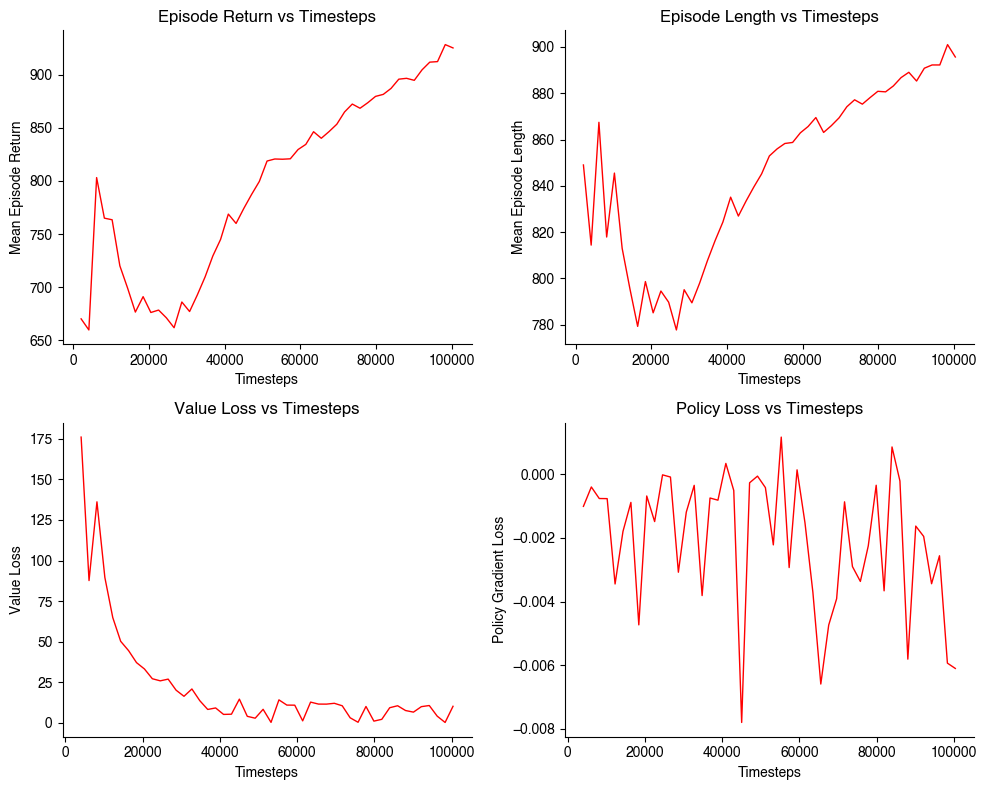

In [7]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Plot PPO training curves for the Upkie pendulum task using Matplotlib.
All plots: red lines, uniform thickness, no grid.
"""

from pathlib import Path
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator
import numpy as np

# Root directory used in train_pendulum_ppo.py
LOG_ROOT = Path("logs/pendulum_task2")

# Tags used by Stable-Baselines3
EP_REW_TAG = "rollout/ep_rew_mean"
EP_LEN_TAG = "rollout/ep_len_mean"
VALUE_LOSS_TAG = "train/value_loss"
POLICY_LOSS_TAG = "train/policy_gradient_loss"

# Style parameters
LINEWIDTH = 1.0
COLOR = "red"


def get_latest_run_dir(log_root: Path) -> Path:
    """Return the most recently modified run subdirectory under log_root."""
    run_dirs = [p for p in log_root.glob("*") if p.is_dir()]
    if not run_dirs:
        raise FileNotFoundError(f"No run subdirectories found in {log_root}")
    run_dirs.sort(key=lambda p: p.stat().st_mtime)
    return run_dirs[-1]


def load_scalars(run_dir: Path, tag: str):
    """Load a scalar time series from a TensorBoard event file."""
    event_files = list(run_dir.glob("events.out.tfevents.*"))
    if not event_files:
        raise FileNotFoundError(f"No event files found in {run_dir}")

    ea = event_accumulator.EventAccumulator(str(event_files[0]))
    ea.Reload()

    if tag not in ea.Tags().get("scalars", []):
        print(f"[WARN] Tag '{tag}' not found in TensorBoard logs.")
        return np.array([]), np.array([])

    scalars = ea.Scalars(tag)
    steps = np.array([s.step for s in scalars], dtype=float)
    values = np.array([s.value for s in scalars], dtype=float)
    return steps, values


def main():
    run_dir = get_latest_run_dir(LOG_ROOT)
    print(f"[INFO] Using run directory: {run_dir}")

    # Load scalar series
    steps_rew, ep_rew = load_scalars(run_dir, EP_REW_TAG)
    steps_len, ep_len = load_scalars(run_dir, EP_LEN_TAG)
    steps_vloss, vloss = load_scalars(run_dir, VALUE_LOSS_TAG)
    steps_ploss, ploss = load_scalars(run_dir, POLICY_LOSS_TAG)

    # Create a 2x2 figure
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    ax1, ax2, ax3, ax4 = axes.flatten()

    # Episode return
    if ep_rew.size > 0:
        ax1.plot(steps_rew, ep_rew, color=COLOR, linewidth=LINEWIDTH)
        ax1.set_title("Episode Return vs Timesteps")
        ax1.set_xlabel("Timesteps")
        ax1.set_ylabel("Mean Episode Return")

    # Episode length
    if ep_len.size > 0:
        ax2.plot(steps_len, ep_len, color=COLOR, linewidth=LINEWIDTH)
        ax2.set_title("Episode Length vs Timesteps")
        ax2.set_xlabel("Timesteps")
        ax2.set_ylabel("Mean Episode Length")

    # Value loss
    if vloss.size > 0:
        ax3.plot(steps_vloss, vloss, color=COLOR, linewidth=LINEWIDTH)
        ax3.set_title("Value Loss vs Timesteps")
        ax3.set_xlabel("Timesteps")
        ax3.set_ylabel("Value Loss")

    # Policy loss
    if ploss.size > 0:
        ax4.plot(steps_ploss, ploss, color=COLOR, linewidth=LINEWIDTH)
        ax4.set_title("Policy Loss vs Timesteps")
        ax4.set_xlabel("Timesteps")
        ax4.set_ylabel("Policy Gradient Loss")

    plt.tight_layout()
    plt.savefig(run_dir / "Task2_training_curves.pdf")
    plt.show()


if __name__ == "__main__":
    main()